# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf
from path_data import paths
from path_data.paths import monthly_pdf, year_pqt, year_day_types_pqt, TEMPLATE_2023, TEMPLATE_2022

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2025, 3)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2025


In [5]:
if year is None:
    year = cur_year

pdf = monthly_pdf(year)
relpath(pdf)

'data/2025-PATH-Monthly-Ridership-Report.pdf'

In [6]:
if last_month is None:
    from PyPDF2 import PdfReader

    reader = PdfReader(pdf)
    num_pages = len(reader.pages)
    last_month = max(1, num_pages - 1)
    err(f"Inferred {last_month=}")

if template is None:
    template = paths.template(year)

Inferred last_month=1


In [7]:
with open(template, 'r') as f:
    rects = json.load(f)
rects

[{'page': 1,
  'extraction_method': 'guess',
  'x1': 54.315,
  'x2': 577.575,
  'y1': 116.00001000000002,
  'y2': 238.40001,
  'width': 523.26,
  'height': 122.4},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 58.14,
  'x2': 577.575,
  'y1': 253.000035,
  'y2': 401.41003500000005,
  'width': 519.4350000000001,
  'height': 148.41},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 58.14,
  'x2': 577.575,
  'y1': 474.999975,
  'y2': 592.809975,
  'width': 519.4350000000001,
  'height': 117.81},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 56.61,
  'x2': 578.34,
  'y1': 611.000145,
  'y2': 753.290145,
  'width': 521.73,
  'height': 142.29},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 273.87,
  'x2': 573.75,
  'y1': 60.8175,
  'y2': 107.4825,
  'width': 299.88,
  'height': 46.665}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[116.00001000000002, 54.315, 238.40001, 577.575],
 [253.000035, 58.14, 401.41003500000005, 577.575],
 [474.999975, 58.14, 592.809975, 577.575],
 [611.000145, 56.61, 753.290145, 578.34],
 [60.8175, 273.87, 107.4825, 573.75]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}
tables

Failed to import jpype dependencies. Fallback to subprocess.
No module named 'jpype'


{1: [                    0          1       2       3       4       5
  0  Christopher Street    103,218   3,832   2,840   1,956   1,782
  1          9th Street     89,377   3,264   2,473   1,771   1,931
  2         14th Street    137,547   5,242   3,486   2,174   2,412
  3         23rd Street    151,719   6,297   2,499   1,389   1,965
  4         33rd Street    515,046  20,113  10,537   7,444  10,374
  5     UPTOWN SUBTOTAL    996,907  38,748  21,835  14,734  18,463
  6                 WTC  1,081,649  42,893  19,990  15,723  19,021
  7   NEW YORK SUBTOTAL  2,078,556  81,641  41,825  30,458  37,483,
                       0          1        2       3       4       5
  0               Newark    394,078   16,042   6,384   4,781   6,269
  1             Harrison    142,274    5,835   2,378   1,560   1,996
  2       Journal Square    544,062   20,814  12,252   9,254  10,478
  3         Grove Street    403,294   15,506   9,690   6,477   6,497
  4       Exchange Place    271,799   10,932   4

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 5:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 5 tables


1

In [12]:
avgs = pd.concat([
    df.assign(date=date(year, month, 1)).astype({ 'date': 'datetime64[s]' })
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs

,0,1,2,3,4,5,date
0,Christopher Street,"103,218","3,832","2,840","1,956","1,782",2025-01-01
1,9th Street,"89,377","3,264","2,473","1,771","1,931",2025-01-01
2,14th Street,"137,547","5,242","3,486","2,174","2,412",2025-01-01
3,23rd Street,"151,719","6,297","2,499","1,389","1,965",2025-01-01
4,33rd Street,"515,046","20,113","10,537","7,444","10,374",2025-01-01
5,UPTOWN SUBTOTAL,"996,907","38,748","21,835","14,734","18,463",2025-01-01
6,WTC,"1,081,649","42,893","19,990","15,723","19,021",2025-01-01
7,NEW YORK SUBTOTAL,"2,078,556","81,641","41,825","30,458","37,483",2025-01-01
0,Newark,"394,078","16,042","6,384","4,781","6,269",2025-01-01
1,Harrison,"142,274","5,835","2,378","1,560","1,996",2025-01-01


In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

,station,total,avg weekday,avg sat,avg sun,avg holiday,month
0,Christopher Street,103218,3832,2840,1956,1782,2025-01-01
1,9th Street,89377,3264,2473,1771,1931,2025-01-01
2,14th Street,137547,5242,3486,2174,2412,2025-01-01
3,23rd Street,151719,6297,2499,1389,1965,2025-01-01
4,33rd Street,515046,20113,10537,7444,10374,2025-01-01
5,UPTOWN SUBTOTAL,996907,38748,21835,14734,18463,2025-01-01
6,WTC,1081649,42893,19990,15723,19021,2025-01-01
7,NEW YORK SUBTOTAL,2078556,81641,41825,30458,37483,2025-01-01
0,Newark,394078,16042,6384,4781,6269,2025-01-01
1,Harrison,142274,5835,2378,1560,1996,2025-01-01


In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station               object
total                  int64
avg weekday            int64
avg sat                int64
avg sun                int64
avg holiday            int64
month          datetime64[s]
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=date(year, month, 1)).astype({ 'date': 'datetime64[s]' })
    for month, dfs in tables.items()
    for df in dfs[2:4]
])
sums

,0,1,2,3,4,5,date
0,Christopher Street,"3,330","80,470","11,360","7,824","3,564",2025-01-01
1,9th Street,"2,883","68,542","9,891","7,083","3,861",2025-01-01
2,14th Street,"4,437","110,084","13,943","8,697","4,823",2025-01-01
3,23rd Street,"4,894","132,236","9,997","5,557","3,929",2025-01-01
4,33rd Street,"16,614","422,373","42,149","29,776","20,748",2025-01-01
5,UPTOWN SUBTOTAL,"32,158","813,705","87,340","58,937","36,925",2025-01-01
6,WTC,"34,892","900,754","79,961","62,893","38,041",2025-01-01
7,NEW YORK SUBTOTAL,"67,050","1,714,459","167,301","121,830","74,966",2025-01-01
0,Newark,"12,712","336,882","25,536","19,123","12,537",2025-01-01
1,Harrison,"4,589","122,534","9,510","6,238","3,992",2025-01-01


In [17]:
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

,station,avg daily,total weekday,total sat,total sun,total holiday,month
0,Christopher Street,3330,80470,11360,7824,3564,2025-01-01
1,9th Street,2883,68542,9891,7083,3861,2025-01-01
2,14th Street,4437,110084,13943,8697,4823,2025-01-01
3,23rd Street,4894,132236,9997,5557,3929,2025-01-01
4,33rd Street,16614,422373,42149,29776,20748,2025-01-01
5,UPTOWN SUBTOTAL,32158,813705,87340,58937,36925,2025-01-01
6,WTC,34892,900754,79961,62893,38041,2025-01-01
7,NEW YORK SUBTOTAL,67050,1714459,167301,121830,74966,2025-01-01
0,Newark,12712,336882,25536,19123,12537,2025-01-01
1,Harrison,4589,122534,9510,6238,3992,2025-01-01


In [18]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [19]:
sums.dtypes

station                 object
avg daily                int64
total weekday            int64
total sat                int64
total sun                int64
total holiday            int64
month            datetime64[s]
dtype: object

In [20]:
def parse_nums(month, tbl):
    assert len(tbl) == 3
    assert all(tbl.iloc[0] == 'Average')
    tbl.columns = tbl.iloc[1].str.lower()
    tbl.columns.name = None
    tbl = tbl.iloc[2:]
    tbl.index = [month]
    tbl.index.name = 'month'
    return tbl.astype(int)
    
nums = pd.concat([
    parse_nums(month=month, tbl=dfs[-1])
    for month, dfs in tables.items()
])
nums.columns = [ f'{c}s' for c in nums.columns ]
nums

,weekdays,saturdays,sundays,holidays
month,,,,
1,21,4,4,2


In [21]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2025-01-01 Christopher Street        3330         3832     2840     1956   
           9th Street                2883         3264     2473     1771   
           14th Street               4437         5242     3486     2174   
           23rd Street               4894         6297     2499     1389   
           33rd Street              16614        20113    10537     7444   
           UPTOWN SUBTOTAL          32158        38748    21835    14734   
           WTC                      34892        42893    19990    15723   
           NEW YORK SUBTOTAL        67050        81641    41825    30458   
           Newark                   12712        16042     6384     4781   
           Harrison                  4589         5835     2378     1560   
           Journal Square           17550        20814    12252     9254   
           Grove Street             13009        15506     9690     6477   
           Exchange Place            8768        10932     4904     3411   
           Newport                   9012        11432     4667     3241   
           Hoboken                  13142        15993     9441     5588   
           NEW JERSEY SUBTOTAL      78783        96554    49714    34311   
           MONTHLY TOTAL           145833       178195    91540    64768   

                                avg holiday    total  total weekday  \
month      station                                                    
2025-01-01 Christopher Street          1782   103218          80470   
           9th Street                  1931    89377          68542   
           14th Street                 2412   137547         110084   
           23rd Street                 1965   151719         132236   
           33rd Street                10374   515046         422373   
           UPTOWN SUBTOTAL            18463   996907         813705   
           WTC                        19021  1081649         900754   
           NEW YORK SUBTOTAL          37483  2078556        1714459   
           Newark                      6269   394078         336882   
           Harrison                    1996   142274         122534   
           Journal Square             10478   544062         437085   
           Grove Street                6497   403294         325635   
           Exchange Place              4479   271799         229581   
           Newport                     3828   279359         240072   
           Hoboken                     5728   407413         335844   
           NEW JERSEY SUBTOTAL        39273  2442279        2027633   
           MONTHLY TOTAL              76756  4520835        3742092   

                                total sat  total sun  total holiday  
month      station                                                   
2025-01-01 Christopher Street       11360       7824           3564  
           9th Street                9891       7083           3861  
           14th Street              13943       8697           4823  
           23rd Street               9997       5557           3929  
           33rd Street              42149      29776          20748  
           UPTOWN SUBTOTAL          87340      58937          36925  
           WTC                      79961      62893          38041  
           NEW YORK SUBTOTAL       167301     121830          74966  
           Newark                   25536      19123          12537  
           Harrison                  9510       6238           3992  
           Journal Square           49006      37016          20955  
           Grove Street             38760      25906          12993  
           Exchange Place           19616      13644           8958  
           Newport                  18666      12965           7656  
           Hoboken                  37763      22351          11455  
           NEW JERSEY SUBTOTAL     198857     1

In [22]:
path = year_pqt(year)
df.to_parquet(path)
err(f"Wrote {relpath(path)}")

Wrote data/2025.pqt


In [23]:
nums_path = year_day_types_pqt(year)
nums.to_parquet(nums_path)
err(f"Wrote {relpath(nums_path)}")

Wrote data/2025-day-types.pqt


In [24]:
import plotly.express as px
from IPython.display import Image

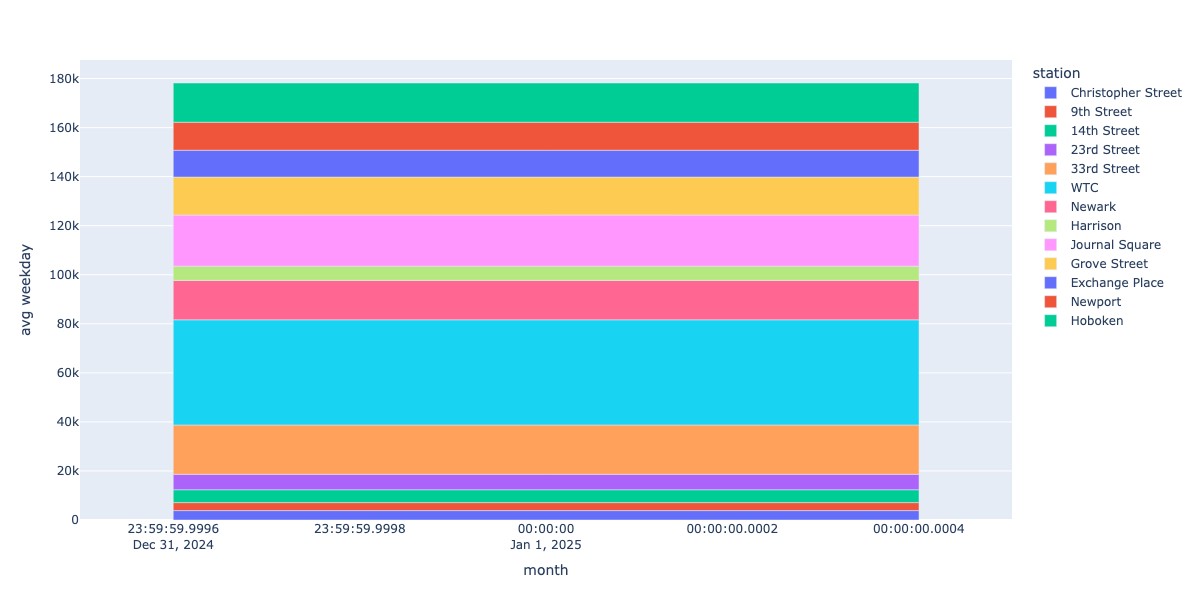

In [25]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))